In [1]:
import matplotlib.pyplot as plt
import scanpy.external as sce
import scrublet as scr
import cellrank as cr
#import fsspec
import seaborn as sns
import scvi
import anndata
import pandas as pd
#import network
import numpy as np
import desc 
import matplotlib
import umap
import h5py
import collections
import os
import anndata
#import igraph
#import networkx
#import pyscenic
import scvelo as scv
import os
import scanpy as sc
import re

#%load_ext rpy2.ipython
%matplotlib inline 

sc.settings.verbosity = 3     

np.random.seed(42)

sc.set_figure_params(figsize=(4, 4), format = 'svg', dpi_save = 300)

Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


# Filtering data based on QC parameters

... reading from cache file cache/Users-brendamelano-Desktop-os_data-OS742-OS742.h5ad


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(


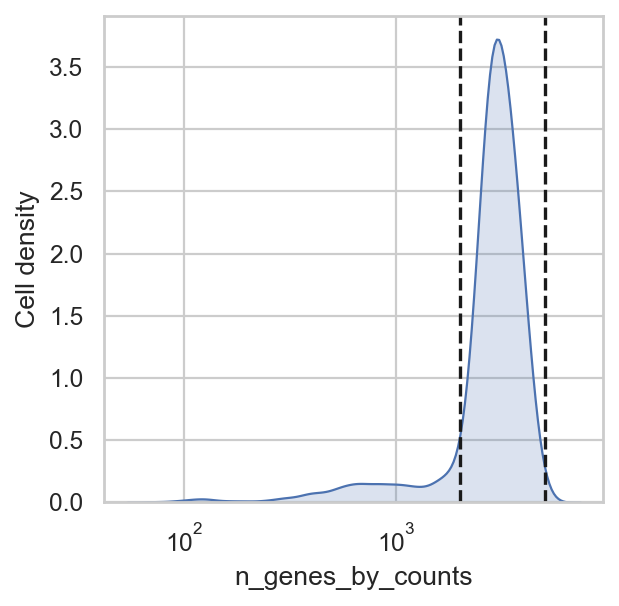

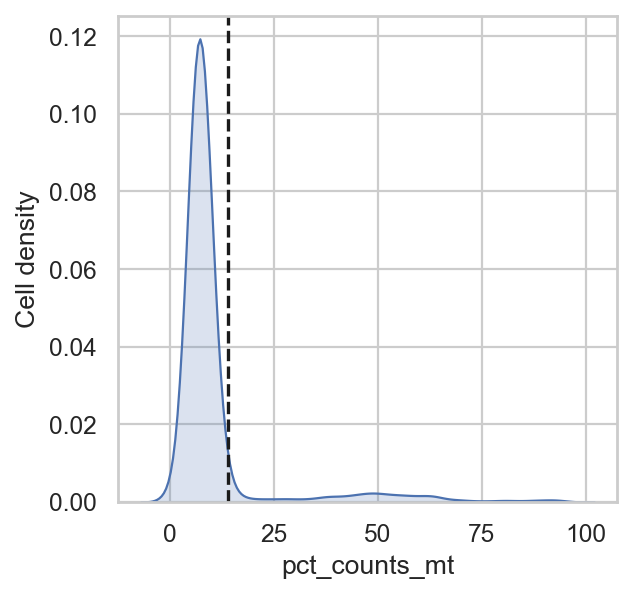

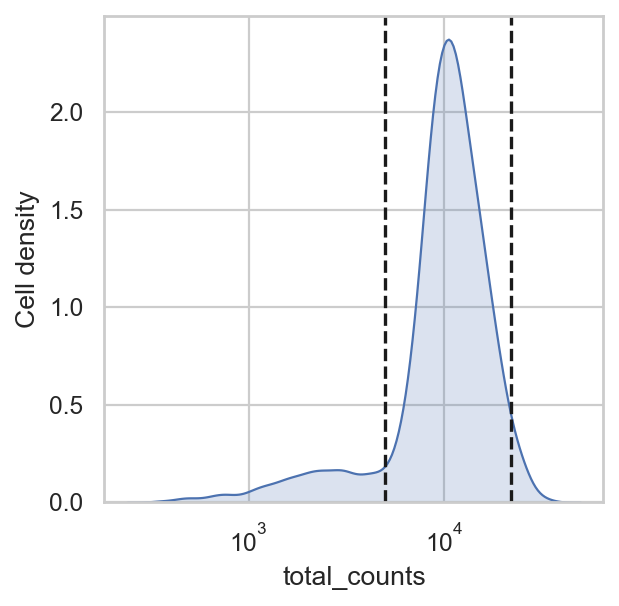

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/core/_anndata.py:640: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[f"initial_size_{layer}"] = get_size(adata, layer)


Filtered out 52560 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
`n_top_genes` > `adata.n_var`, returning all genes.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
97
78
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    759 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    748 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
regressing out ['n_counts', 'pct_counts_mt', 'ccdifference']
    sparse input is densified and may lead to high memory use


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


    finished (0:00:09)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


In [17]:
# reading in OS742 loom file
adata = scv.read('/Users/brendamelano/Desktop/os_data/OS742/OS742.loom', cache = True)


# Making the var names unique
adata.var_names_make_unique()


# Filtering as is done in Seurat
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

# Computing mitochondrial percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

plt.figure()
sns.kdeplot(data=adata.obs, x='n_genes_by_counts', fill=True, alpha=0.2, log_scale=True)


# Add a vertical line at x = 20000
plt.axvline(x=5000, color='k', linestyle='--')
plt.axvline(x=2000, color='k', linestyle='--')


# Set labels and a classic theme
plt.xlabel("n_genes_by_counts")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()


## Percent mitochondrial reads

#This may only show up correctly after filtering
plt.figure()
sns.kdeplot(data=adata.obs, x='pct_counts_mt', fill=True, alpha=0.2)

# Add a vertical line at x = 20000
plt.axvline(x=14, color='k', linestyle='--')

# Set labels and a classic theme
plt.xlabel("pct_counts_mt")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()


plt.figure()
sns.kdeplot(data=adata.obs, x='total_counts', fill=True, alpha=0.2, log_scale=True)

# Add a vertical line at x = 20000
plt.axvline(x=5000, color='k', linestyle='--')
plt.axvline(x=22000, color='k', linestyle='--')

# Set labels and a classic theme
plt.xlabel("total_counts")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()

# Filtering the adata set based on total counts, genes and mitochondrial percentage
adata = adata[(adata.obs['total_counts'] >= 5000) &
                        (adata.obs['total_counts'] <= 22000) &
                        (adata.obs['n_genes_by_counts'] >= 2000) &
                        (adata.obs['n_genes_by_counts'] < 5000) & #pct_counts_mt
                        (adata.obs['pct_counts_mt'] < 12)
                        ]

# weren't the samples filtered in seurat? check which additional cells and genes are filtered out here
scv.pp.filter_genes(adata, min_shared_counts=20)


# normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)


# filtering the dataset to only keep the most variable genes
# this is redundant to selecting highly variable genes
scv.pp.filter_genes_dispersion(adata, n_top_genes=2000)


# Log scaling
scv.pp.log1p(adata)


# preserving the counts
adata.layers["counts"] = adata.X.copy() 



# freezing the data in raw
adata.raw = adata


# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# Selecting highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000, 
    subset=True,
    layer="counts"
)

genes = adata.var.index.values

# reading in cell cycle genes in case I want to regress on that
cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))


sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']

# Linear dimensionality reduction
#sc.pp.normalize_total(adata, target_sum=1e4)

#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt', 'ccdifference'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')



computing neighbors
    using 'X_pca' with n_pcs = 35
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)
running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


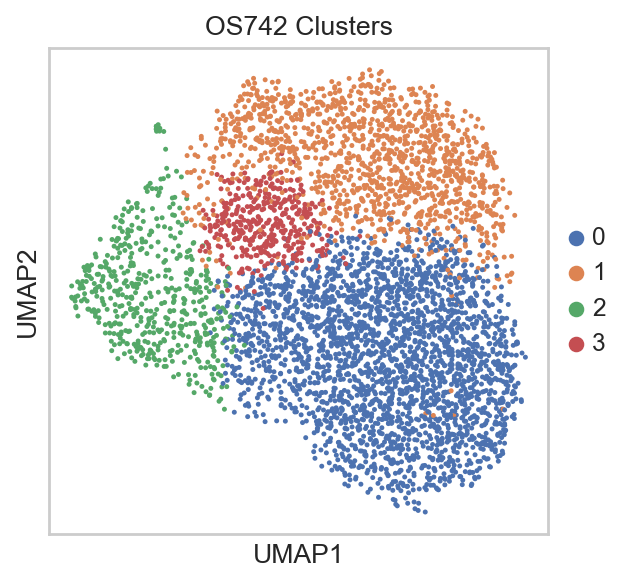

In [18]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=35)
sc.tl.umap(adata)

sc.tl.leiden(adata, resolution = 0.3)

sc.pl.umap(
    adata,
    color=["leiden"],
    frameon= True,
    title = "OS742 Clusters",
    size = 20
)

# Marker identification

In [3]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
cluster_markers = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(60)
cluster_markers

Subtype_A_genes_742 = cluster_markers.iloc[:, 0].tolist()

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


,0,1,2,3,4,5,6
0,RPS12,AMBN,UBE2S,ATAD2,PANX3,RPS5,CAV1
1,RPS6,COL1A2,HSP90AA1,HMGB2,SPARC,RPL8,IGFBP7
2,MARCKS,AOC2,RANBP1,UBE2T,BGN,ISG15,TPM1
3,CDKN2A,S100A13,SNRPB,TUBB,TMEM119,FTL,PLAU
4,QPRT,ANO5,PTTG1,TUBA1B,COL1A2,RPS4X,TMSB4X
5,FTH1,SDC2,CDKN3,TYMS,ALPL,GAPDH,CALD1
6,CSRP2,RPS3A,NUCKS1,MCM3,S100A4,SH3BGRL3,GPNMB
7,ACAT2,SERPINF1,H2AZ1,TUBB4B,PHOSPHO1,TIMP1,HLA-C
8,SLC38A2,RPS5,NEFH,MCM7,COL1A1,RPS3A,COL11A1
9,PNRC1,CREB3L1,TUBA1B,TOP2A,S100A6,IFI27,VIM


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


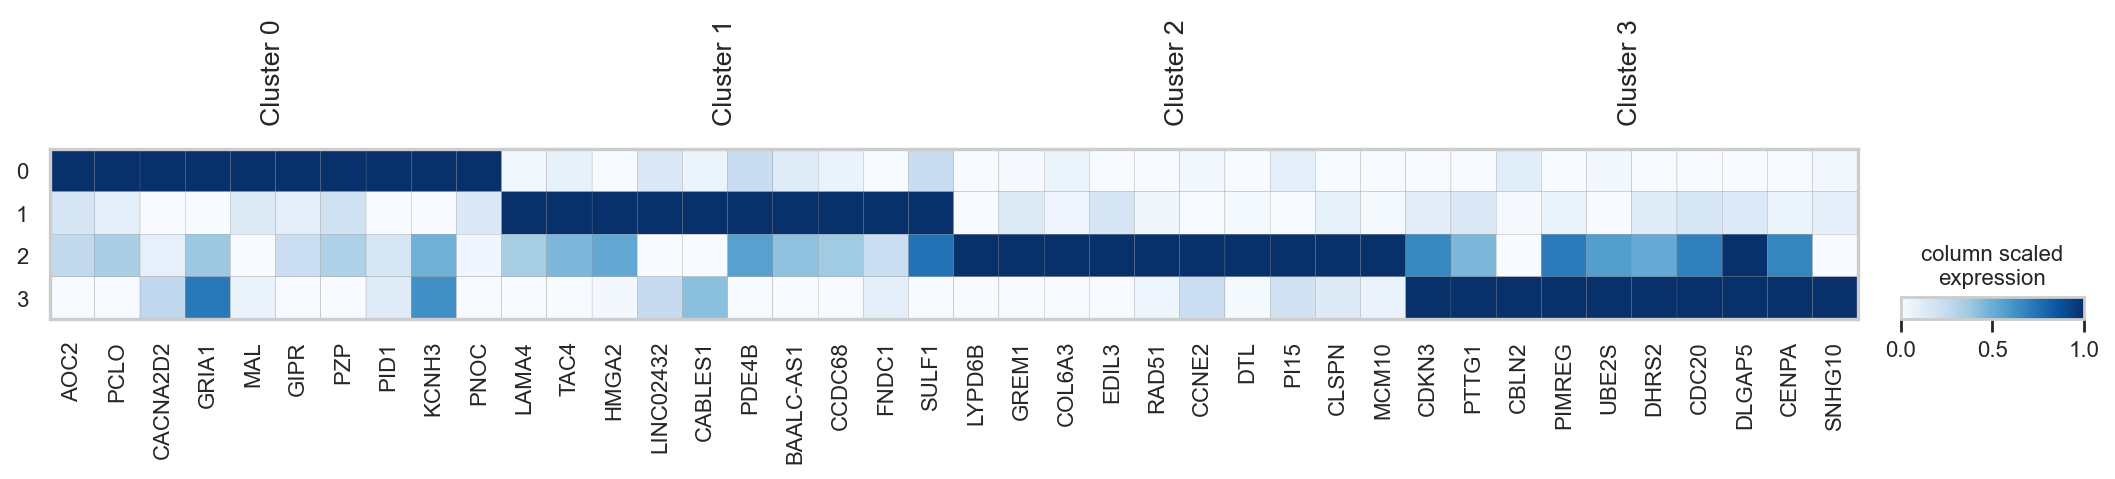

In [25]:


# Perform Differential Gene Expression Analysis
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

# Extract gene names and log fold changes into a DataFrame
gene_names_df = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
logfc_df = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])

# Filter for logFC > 1. This involves checking each gene's logFC across all clusters
# and selecting the gene if it has logFC > 1 in any of the clusters.
filtered_genes = gene_names_df[logfc_df > 1].stack().reset_index(level=1, drop=True).unique()

top_genes_by_cluster = {}  # Dictionary to hold top genes for each cluster

# Assuming gene_names_df and logfc_df have been correctly defined as before
num_clusters = gene_names_df.shape[1]

for cluster_idx in range(num_clusters):
    sorted_genes = logfc_df.iloc[:, cluster_idx].sort_values(ascending=False).head(10).index
    top_genes = gene_names_df.iloc[sorted_genes, cluster_idx].values
    top_genes_by_cluster[f"Cluster {cluster_idx}"] = top_genes
    
sc.pl.matrixplot(
    adata,
    top_genes_by_cluster,
    "leiden",
    #dendrogram=True,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
)

# Write the array to a CSV file
#np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742_subtype_A_markers.csv", Subtype_A_genes_742, delimiter=",", fmt='%s')


computing score 'angiogenic_score'
    finished: added
    'angiogenic_score', score of gene set (adata.obs).
    98 total control genes are used. (0:00:00)


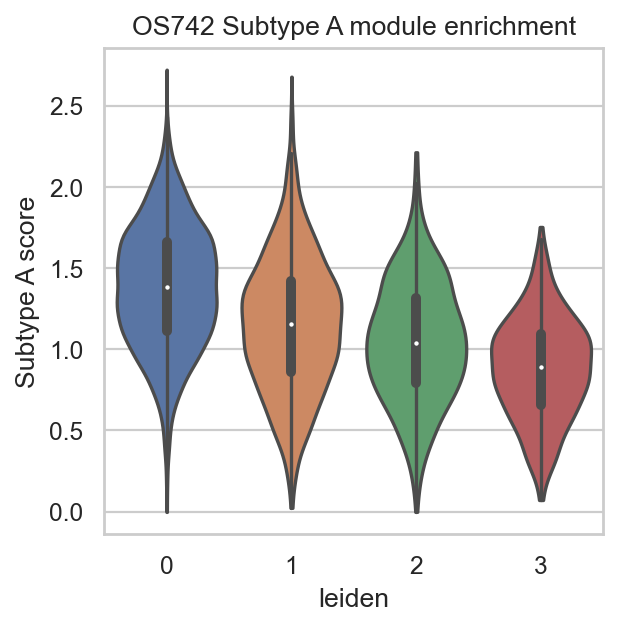

In [26]:

# Reading in Subtype "A" gene lists for gsea
Subtype_A_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_A_module.csv')]


adata.var_names_make_unique()


# keeping only genes that appear in the adata
Subtype_A_genes = [x for x in Subtype_A_genes if x in adata.var_names]


# Computing gsea
sc.tl.score_genes(adata, Subtype_A_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='angiogenic_score', random_state=0, copy=False, use_raw=None)



# Explicitly create a figure and axes before plotting
fig, ax = plt.subplots(figsize=(4, 4))  # You can adjust the figure size as needed


# Plot the violin plot on the specified axes (ax)
sc.pl.violin(adata, ['angiogenic_score'], groupby='leiden',
             stripplot=False, inner='box', ylabel='Subtype A score',
             show=False, ax=ax)  # Pass the ax argument here

# Set the title on the axes object
ax.set_title('OS742 Subtype A module enrichment')

# Show the plot
plt.show()




# Subtype B module identification

In [4]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = '3'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS742_subtype_B_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)

OS742_subtype_B_markers

,genes,p_values,adjusted_p_values,log_fold_changes,scores
14,CDK1,9.757496e-172,9.757496e-170,3.833520,27.935984
13,CLSPN,2.133853e-177,2.286272e-175,3.686475,28.398108
11,UBE2C,2.481460e-180,3.101826e-178,3.667577,28.634764
37,MCM10,1.701894e-116,6.718001e-115,3.547619,22.943731
18,MKI67,4.434210e-157,3.500692e-155,3.444921,26.702230
9,TOP2A,2.494296e-182,3.741444e-180,3.412023,28.794767
44,NDC80,1.282491e-108,4.274969e-107,3.371722,22.140694
1,HMGB2,1.486821e-210,1.115115e-207,3.338814,30.967289
24,GTSE1,9.005644e-144,5.403386e-142,3.260898,25.530657
22,RAD51AP1,4.687327e-147,3.056952e-145,3.246219,25.824659


In [5]:
OS742_subtype_B_markers = OS742_subtype_B_markers.iloc[:, 0].tolist()

OS742_subtype_B_markers


['CDK1',
 'CLSPN',
 'UBE2C',
 'MCM10',
 'MKI67',
 'TOP2A',
 'NDC80',
 'HMGB2',
 'GTSE1',
 'RAD51AP1',
 'CDC45',
 'NCAPG',
 'AURKB',
 'KIF23',
 'ATAD2',
 'AURKA',
 'CCNA2',
 'ASPM',
 'DSCC1',
 'PCNA',
 'MYBL2',
 'HMMR',
 'TYMS',
 'UBE2T',
 'DLGAP5',
 'MCM7',
 'ORC6',
 'CENPF',
 'MCM5',
 'MCM3',
 'WDHD1',
 'TK1',
 'TUBB4B',
 'PRIM1',
 'BIRC5',
 'GMNN',
 'ZWINT',
 'USP1',
 'TPX2',
 'CDKN3',
 'SMC4',
 'CENPM',
 'RFC4',
 'KPNA2',
 'H2AX',
 'TUBA1B',
 'CKS2',
 'MAD2L1',
 'TUBG1',
 'TMPO',
 'RRM1',
 'TUBB',
 'DEK',
 'DUT',
 'DNMT1',
 'CENPX',
 'TUBA1C',
 'RANBP1',
 'SMC3',
 'H2AZ1']

In [6]:
np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742_subtype_B_markers.csv", OS742_subtype_B_markers, delimiter=",", fmt='%s')


# Subtype C module identification

In [8]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = '0'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS742_subtype_C_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)

OS742_subtype_C_markers = OS742_subtype_C_markers.iloc[:, 0].tolist()

OS742_subtype_C_markers

np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS742_subtype_C_markers.csv", OS742_subtype_C_markers, delimiter=",", fmt='%s')


# Immune Modulating subtype quantification

In [8]:
# reading in gene lists for gsea
immune_modulating_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/immune_modulating_genes.csv')]


immune_modulating_genes

print(len(immune_modulating_genes))
# keeping only genes that appear in the adata
immune_modulating_genes = [x for x in immune_modulating_genes if x in adata.var_names]
print(len(immune_modulating_genes))

# plotting the clusters
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon=False,
)

# computing gsea
sc.tl.score_genes(adata, immune_modulating_genes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='immune_modulating_genes', random_state=0, copy=False, use_raw=None)
sc.pl.violin(adata, ['immune_modulating_genes'], groupby='leiden', stripplot=False, inner='box')

sc.pl.umap(
    adata,
    color=["immune_modulating_genes"],
    frameon=False,
)

['HIST1H1B',
 'CLSPN',
 'CDK1',
 'HIST1H1E',
 'MKI67',
 'UBE2C',
 'HIST1H4C',
 'HMGB2',
 'AURKB',
 'UBE2T',
 'TOP2A',
 'TUBB',
 'KIF23',
 'TUBB4B',
 'H2AFX',
 'AURKA',
 'CKS2',
 'CENPE',
 'KPNA2']

# scVI

In [4]:


# reading in the cell IDs, umap embeddings and cluster identities from the seurat object
sample_obs = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS742/cellID_obs_742.csv")


# reading in the ccdifference scores
ccdifference = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS742/CCdifference.csv")


# reading in the percent.mt scores
percent_mt = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS742/percent.mt.csv")


# removing the suffix and prefix from the index column within the adata object
adata.obs.index = adata.obs.index.map(lambda x: x.lstrip('OS742:').rstrip('x'))


# removing the suffix from the seurat barcodes
sample_obs["x"] = sample_obs["x"].map(lambda x: x.lstrip('').rstrip('-1'))


# filtering the adata object based on the seurat sample observations
adata = adata[np.isin(adata.obs.index,sample_obs["x"])]


# filtering genes based on those that have at least 10 counts
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.filter_cells(adata, min_counts=200)


# making a copy of the counts to preserve them
adata.layers["counts"] = adata.X.copy() 


# normalizing the data
sc.pp.normalize_total(adata, target_sum=1e4)


# log normalizing the data
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`. What is the purpose of this?


# feature selection
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000, # try 3k or 4k How can I automate trying different top variable genes
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)


# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# concatenating the umap embeddings and the cluster identity
objs = [sample_obs, ccdifference]


# concatenating the objects
ccdif = pd.concat(objs, axis = 1, ignore_index = True)


# dropping the 3rd column from the umap clusters df
ccdif = ccdif.drop(columns = 1)


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {0:'CellID'})


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {2:'ccdifference'})


# concatenating the umap embeddings and the cluster identity
objs = [ccdif, percent_mt]
ccdif = pd.concat(objs, axis = 1, ignore_index = True)

# dropping the 3rd column from the umap clusters df
ccdif = ccdif.drop(columns = 2)


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {0:'CellID'})


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {1:'ccdifference'})


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {3:'percent.mt'})


# ordering the umap object based on the sample index
ccdif_ordered = sample_one_index.merge(ccdif, on = "CellID")


## FILTERING

# filtering the adata object based on the seurat sample observations
adata = adata[np.isin(adata.obs.index, ccdif["CellID"])]


# filtering the adata object based on the seurat sample observations
ccdif_ordered = ccdif_ordered[np.isin( ccdif_ordered["CellID"], adata.obs.index)]


# filtering the adata object based on the seurat sample observations
adata = adata[np.isin(adata.obs.index,ccdif_ordered["CellID"])]




# setting the index of the dataframe to 'CellID'
ccdif_ordered = ccdif_ordered.set_index('CellID')


# isolating the ccdifference values
ccdif_values = ccdif_ordered['ccdifference']


adata.obs['ccdifference'] = ccdif_values.values


# assigning the cluster ids to the adata object
adata.obs['ccdifference'] = ccdif_ordered['ccdifference']


# adding percent mt reads to the adata object
adata.obs['percent.mt'] = ccdif_ordered['percent.mt']


# setting up the anndata object to include continuous covariate variables
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    continuous_covariate_keys=["percent.mt", "ccdifference"]
)


# creating a model for my adata object
model = scvi.model.SCVI(adata)

# inspecting the structure of the model
model

# training the model
model.train()

# saving my model
model.save("OS742_scvi/")

# loading the model
#model = scvi.model.SCVI.load("OS742_scvi_model/", adata, use_gpu=False)

# saving the normalized expression in a different layer 
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

# getting the latent representation
latent = model.get_latent_representation()

# adding the latent variables to the adata object
adata.obsm["X_scVI"] = latent

# using the latent space for umap generation
sc.pp.neighbors(adata, use_rep="X_scVI")


# computing umap
sc.tl.umap(adata, min_dist=0.3)


# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=1)

# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.3)


# plotting the clusters
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon=False,
)

adata.var_names_make_unique()

# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/os_data/OS742/scvi_742_adata.h5ad")



## Identifying cluster specific markers

# comparing each cell type to the rest
de_df = model.differential_expression(
    groupby="leiden_scVI",
)


de_df.head()

# identifying the top markers within each cluster
markers = {}


cats = adata.obs.leiden_scVI.cat.categories
for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 1]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 1]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:30]
    
subtype_A_markers = {key: markers[key] for key in ['0', '1'] if key in markers}

subtype_A_markers = sum(subtype_A_markers.values(), [])

# Convert the list to a NumPy array
subtype_A_markers = np.array(subtype_A_markers)

# Reshape the array to be two-dimensional, which is needed for savetxt
subtype_A_markers = subtype_A_markers.reshape(-1, 1)

# Write the array to a CSV file
np.savetxt("/Users/brendamelano/Desktop/subtype_A_markers.csv", subtype_A_markers, delimiter=",", fmt='%s')

# heatmap
sc.pl.heatmap(
    adata_filtered, 
    markers, 
    groupby='cell_type', 
    layer="scvi_normalized",
    standard_scale="var",
    dendrogram=True,
    figsize=(8, 12)
)

filtered out 44967 genes that are detected in less than 10 counts
normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


# GSEA

In [8]:
# Defining the directory for the gmt files
directory = '/Users/brendamelano/Desktop/gmt_files'

# Create a dictionary to store gene lists
gene_lists = {}

# Create variables for gene lists
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        variable_name = os.path.splitext(filename)[0].upper()
        variable_name += "_genes"
        with open(os.path.join(directory, filename)) as f:
            gene_lists[variable_name] = [line.strip() for line in f]

# Create a dictionary to store gene scores for each module
gene_scores = {}

# Quantify enrichment for each gene list
for gene_list_name, gene_list in gene_lists.items():
    scores_key = gene_list_name + "_score"
    try:
        gene_scores[gene_list_name] = sc.tl.score_genes(
            adata, gene_list, ctrl_size=50, gene_pool=None,
            n_bins=5, score_name=scores_key, random_state=0, 
            copy=False, use_raw=None
        )
    except KeyError:
        continue

        
adata.var_names_make_unique()





computing score 'IL2_genes_score'
    finished: added
    'IL2_genes_score', score of gene set (adata.obs).
    148 total control genes are used. (0:00:00)
computing score 'MTOR_genes_score'
    finished: added
    'MTOR_genes_score', score of gene set (adata.obs).
    193 total control genes are used. (0:00:00)
computing score 'FOCAL_ADHESION_PI3KAKTMTOR_genes_score'
    finished: added
    'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    191 total control genes are used. (0:00:00)
computing score 'PDGF_ERK1_DOWN_genes_score'
    finished: added
    'PDGF_ERK1_DOWN_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'TNFA_genes_score'


    finished: added
    'TNFA_genes_score', score of gene set (adata.obs).
    149 total control genes are used. (0:00:00)
computing score 'GCNP_genes_score'
    finished: added
    'GCNP_genes_score', score of gene set (adata.obs).
    196 total control genes are used. (0:00:00)
computing score 'CSR_genes_score'
    finished: added
    'CSR_genes_score', score of gene set (adata.obs).
    193 total control genes are used. (0:00:00)
computing score 'ESC_genes_score'
    finished: added
    'ESC_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'PI3KAKTMTOR_genes_score'
    finished: added
    'PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    99 total control genes are used. (0:00:00)
computing score 'STK33_genes_score'
    finished: added
    'STK33_genes_score', score of gene set (adata.obs).
    191 total control genes are used. (0:00:00)
computing score 'VEGFA_genes_score'


    finished: added
    'VEGFA_genes_score', score of gene set (adata.obs).
    193 total control genes are used. (0:00:00)
computing score 'KRAS_genes_score'
    finished: added
    'KRAS_genes_score', score of gene set (adata.obs).
    198 total control genes are used. (0:00:00)
computing score 'TGFB_genes_score'
    finished: added
    'TGFB_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'EMT_genes_score'
    finished: added
    'EMT_genes_score', score of gene set (adata.obs).
    195 total control genes are used. (0:00:00)
computing score 'EZH2_genes_score'
    finished: added
    'EZH2_genes_score', score of gene set (adata.obs).
    195 total control genes are used. (0:00:00)
computing score 'LEF1_genes_score'
    finished: added
    'LEF1_genes_score', score of gene set (adata.obs).
    195 total control genes are used. (0:00:00)


In [ ]:

# PI3K/AKT
adata.var_names_make_unique()

# keeping only genes that appear in the adata
PI3KAKTMTOR = [x for x in PI3KAKTMTOR if x in adata.var_names]
print(len(PI3KAKTMTOR))

# computing gsea
sc.tl.score_genes(adata, VEGFA_genes, ctrl_size=50, gene_pool=None, n_bins=5, score_name='VEGFA_score', random_state=0, copy=False, use_raw=None)
sc.pl.violin(adata, ['VEGFA_score'], groupby='leiden_scVI', stripplot=False, inner='box')

# GSEA for PI3K/AKT
# computing gsea
sc.tl.score_genes(adata, PI3KAKTMTOR, ctrl_size=50, gene_pool=None, n_bins=25, score_name='PI3KAKTMTOR', random_state=0, copy=False, use_raw=None)
sc.pl.violin(adata, ['PI3KAKTMTOR'], groupby='leiden', stripplot=False, inner='box')


sc.pl.stacked_violin(adata, PI3KAKTMTOR, groupby='leiden',
                         var_group_positions=[(7, 8)], var_group_labels=['cluster'],
                    standard_scale="var",)

In [9]:

sc.pl.umap(
    adata,
    color=["CSR_genes_score"],
    frameon=False,
)

KeyError: "Could not find keys '['OXPHOS_genes_score']' in columns of `adata.obs` or in adata.var_names."

In [19]:
scores = [ 'IL2_genes_score',  'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', 'ESC_genes_score',
          'TGFB_genes_score', 'STK33_genes_score','PDGF_ERK1_DOWN_genes_score', 'TNFA_genes_score', 'GCNP_genes_score', 
           
             
          'CSR_genes_score','MTOR_genes_score', 'LEF1_genes_score','KRAS_genes_score']


sc.pl.matrixplot(
    adata,
    scores,
    "leiden",
    dendrogram=False,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
)

# Combining the clusters

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


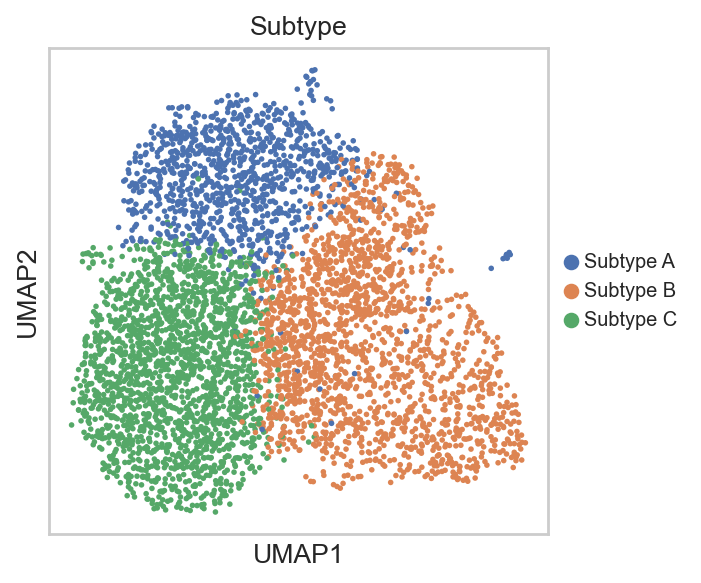

In [16]:
adata.obs['leiden'] = adata.obs['leiden'].astype('category')

adata.obs['leiden'][adata.obs['leiden']=='1']='3'

adata.obs['leiden'][adata.obs['leiden']=='4']='2'



# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'Subtype C': ['0'], 'Subtype B': ['3'], 'Subtype A': ['2']}


# Initialize empty column in cell metadata
adata.obs['Subtype'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'Subtype'] = i

    
sc.pl.umap(adata, color=['Subtype'], legend_fontsize=9)

In [32]:
# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/os_data/OS742/scvi_742_adata_subtypes.h5ad")

# RNA velocity

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on distances
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/642 [00:00<?, ?gene/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:721: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/tools/dynamical_model.py:724: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:05:50) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/4776 [00:00<?, ?cells/s]

/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/scvelo/core/_parallelize.py:138: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(res) if as_array else res


    finished (0:00:08) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


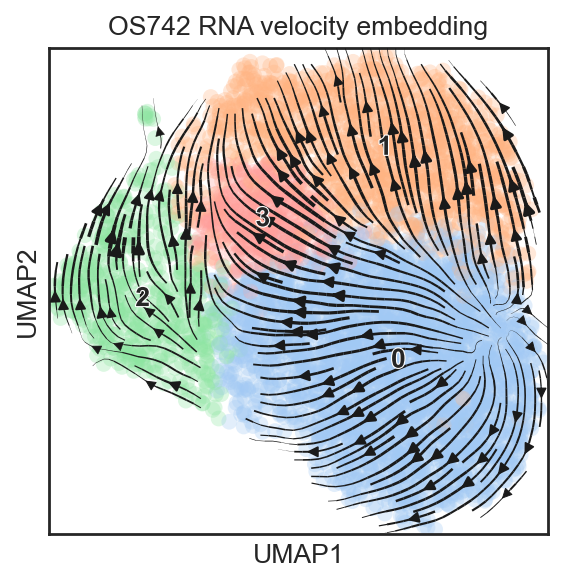

In [27]:
# computing the moments
scv.pp.moments(adata, mode = 'distances')
 

# recovering dynamics
scv.tl.recover_dynamics(adata)

# inferring the DYNAMIC velocities
scv.tl.velocity(adata, mode='dynamical')


# computing the velocity graph
scv.tl.velocity_graph(adata)

# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden'].astype('int64').values)

# Define the number of clusters
n_clusters = len(clusters[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_clusters)

# Create a dictionary that maps each cluster ID to a color from the palette
cluster_colors = dict(zip(sorted(clusters[0].unique()), colors))

# Map the cluster IDs to their corresponding colors
adata.uns['ClusterName_colors'] = [cluster_colors[c] for c in clusters[0]]

# Set the plot style to 'white' to remove grid lines
sns.set_style('white')

# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, basis='umap', 
                                 color='leiden', 
                                 palette=colors, title = 'OS742 RNA velocity embedding',
                                frameon = True)

In [ ]:
# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, basis='umap', color='Subtype', 
                                 palette=colors, title = 'OS742 RNA velocity embedding',
                                frameon = True)